### Problem 3
Attached with this assignment is a data file that contains measurements of the galaxy
stellar mass function from the COSMOS galaxy survey. The columns are:
1. log M_gal [dex]
2. n(M_gal) [1/dex/Volume]
3. error in n (M_gal)

Here, “dex” means base-10 log of the stellar mass. Volume here is (Mpc/h)3 . Measurements of
this type are usually described by a “Schechter” function, which for this problem has the form

$$
n(M_{\text{gal}}) = \phi^* \left( \frac{M_{\text{gal}}}{M_*} \right)^{\alpha + 1} 
\exp\left(-\frac{M_{\text{gal}}}{M_*}\right) \ln(10)
$$

This function (which has the same units as column 2 in the datafile) has three free parameters:
$\phi^*$, the amplitude, $M^*$, the “characteristic mass scale”, where the function changes from being
a power-law to having an exponential cutoff, and α, the low-mass slope of the function.




Write a code that will implement the gradient descent method in multiple dimensions, using
numerical derivatives, to find the minimum of a function. Test your code on a simple function,
such as:

$$
f(x, y) = (x - 2)^2 + (y - 2)^2
$$


(Remember that we’re still using numerical derivatives, even though the derivatives of this
function are known.) After confirming that your code works (include a plot demonstrating this
result— use your discretion to choose what the plot should show), apply it to the problem of fitting the Schechter function to the data provided. The function you are minimizing is the chi^2
of model. Verify that your result is robust by demonstrating that you get the same result when
starting from distinct locations in parameter space (within reason). Attach the following plots:



(a) $\chi^2$ as a function of step $i$.  
(b) a comparison of your best-fit Schechter function to the data, on a log-log plot.  


If you want to attach more plots to help you explain your results, feel free to do so.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Numerical gradient
def central_diff_grad(fun, x, eps=1e-6):
    grad = np.zeros_like(x)
    for i in range(len(x)): 
        h = np.zeros_like(x)
        h[i] = eps
        grad[i] = (fun(x+h) - fun(x-h)) / (2*eps)
    return grad


def gradient_descent(fun, x0, max_iter=2000, tol=1e-8, gtol=1e-6, step_initial=1.0, c=1e-4, rho=0.5, grad_fun=None):
    x = np.array(x0, dtype=float)
    f = fun(x)
    path = [(0, f, *x)]
    for k in range(1, max_iter+1):
        g = grad_fun(x) if grad_fun is not None else central_diff_grad(fun, x)
        gnorm = np.linalg.norm(g, ord=2)
        if gnorm < gtol:
            break

        # backtracking
        step = step_initial
        phi0 = f
        while True:
            xn = x - step * g
            fn = fun(xn)
            if fn <= phi0 - c * step * gnorm**2:
                break
            step *= rho # update step
            if step < 1e-12: # if step gets too small get outttt
                break
        # update
        if abs(fn - f) < tol * (1 + abs(f)):
            x, f = xn, fn
            path.append((k, f, *x))
            break
        x, f = xn, fn
        path.append((k, f, *x))
    info = {
        "iters": k,
        "grad_norm": gnorm,
        "path": np.array(path)
    }
    return x, f, info

xmin ≈ [1.99998946 2.00000575]   f(xmin) = 1.4403171311274998e-10


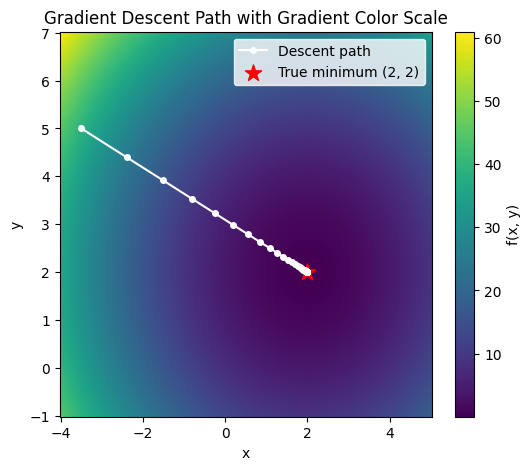

In [2]:
# test simple function: f(x,y) = (x-2)^2 + (y-2)^2
def f_test(v):
    x, y = v
    return (x - 2.0)**2 + (y - 2.0)**2

x0 = [-3.5, 5]
xmin, f_star, info_test = gradient_descent(f_test, x0, step_initial=0.1, tol=1e-10)
print("xmin ≈", xmin, "  f(xmin) =", f_test(xmin))
path = info_test["path"]

plt.figure(figsize=(6, 5))

# make a smooth color map of f(x,y)

xs = np.linspace(-4, 5, 200)
ys = np.linspace(-1, 7, 200)
X, Y = np.meshgrid(xs, ys)
Z = (X-2.0)**2 + (Y-2.0)**2

plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='f(x, y)')

# plot the gradient descent path
plt.plot(path[:, 2], path[:, 3], color='white', marker='o', linewidth=1.5, markersize=4, label='Descent path')
plt.scatter([2], [2], marker='*', color='red', s=150, label='True minimum (2, 2)')

# add labels and polish
plt.title("Gradient Descent Path with Gradient Color Scale")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(edgecolor='white')
plt.show()


In [3]:
import numpy as np

data = np.loadtxt("smf_cosmos.dat", delimiter=" ", usecols=(0,1,2))
log10M, n_obs, err = data[:,0], data[:,1], data[:,2]

def schechter_model(log10M, phi, log10Mstar, step):
    LN10 = np.log(10.0)
    x = log10M - log10Mstar
    t = np.exp(LN10 * x)
    logn = np.log(phi) + np.log(LN10) + (step + 1.0)*LN10*x - t

    return np.exp(logn)

def unpack_theta(theta):
    log10phi, log10Mstar, step = theta

    # fix: keep best fit optimizer from wandering into wacko ranges
    log10phi = float(np.clip(log10phi, -12.0, 2.0)) # phi ~ 1e-12 .. 1e2
    log10Mstar = float(np.clip(log10Mstar, 7.0, 13.0)) # stellar masses in log10
    step = float(np.clip(step, -3.0, 2.0))

    phi = 10.0**log10phi
    return phi, log10Mstar, step

def chi2(theta):
    phi, lMstar, step = unpack_theta(theta)
    model = schechter_model(log10M, phi, lMstar, step)

    r = (n_obs - model) / err
    return np.sum(r*r)

rng = np.random.default_rng(1092039129) # raaandom seed
n_starts = 12
starts = np.column_stack([
    rng.uniform(-6.0, 0.0, size=n_starts), # log10 phi*
    rng.uniform(9.5, 11.5, size=n_starts), # log10 M*
    rng.uniform(-2.0, 0.5, size=n_starts)  # step
])

# find best
best = None
runs = []
for i, x0 in enumerate(starts):
    x_opt, f_opt, info = gradient_descent(chi2, x0, max_iter=2000, tol=1e-9, gtol=1e-6, step_initial=1.0, c=1e-4, rho=0.5)
    runs.append((x0, x_opt, f_opt, info))
    if (best is None) or (f_opt < best[2]):
        best = (x0, x_opt, f_opt, info)

x0_best, theta_best, chi2_best, info_best = best
phi_b, log10Mstar_b, step_b = unpack_theta(theta_best)
ndof = max(1, len(n_obs) - 3)
chi2_red = chi2_best / ndof

print(f"\nBest fit (from {n_starts} random starts):")
print(f"  log10 phi*  = {np.log10(phi_b):.4f}")
print(f"  phi*        = {phi_b:.4e}")
print(f"  log10 M*    = {log10Mstar_b:.4f}")
print(f"  step       = {step_b:.4f}")
print(f"  chi2        = {chi2_best:.3f}")
print(f"  chi2_red    = {chi2_red:.3f}  (ndof = {ndof})")

# Smooth model curve for plotting
log10M_grid = np.linspace(log10M.min()-0.1, log10M.max()+0.1, 400)
n_fit = schechter_model(log10M_grid, phi_b, log10Mstar_b, step_b)



Best fit (from 12 random starts):
  log10 phi*  = -2.5683
  phi*        = 2.7024e-03
  log10 M*    = 10.9762
  step       = -1.0094
  chi2        = 2.908
  chi2_red    = 0.323  (ndof = 9)


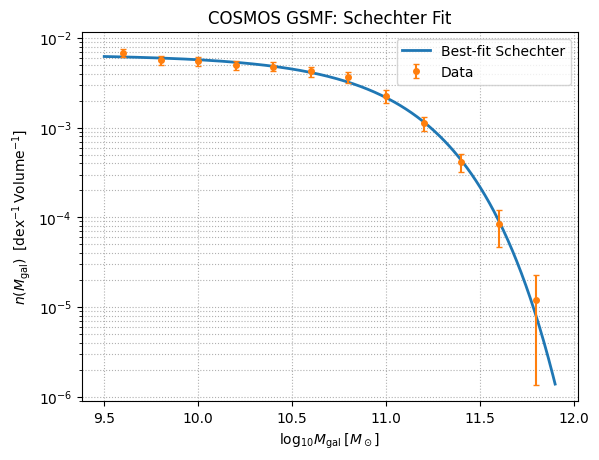

In [4]:
# Plot Schechter fit
plt.figure()
plt.plot(log10M_grid, n_fit, lw=2, label='Best-fit Schechter')
plt.plot()
plt.xlabel(r'$\log_{10} M_{\rm gal} \; [M_\odot]$')
plt.ylabel(r'$n(M_{\rm gal})\;\;[{\rm dex}^{-1}\,{\rm Volume}^{-1}]$')
plt.errorbar(log10M, n_obs, yerr=err, fmt='o', ms=4, capsize=2, label='Data')
plt.yscale('log')
plt.title('COSMOS GSMF: Schechter Fit')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


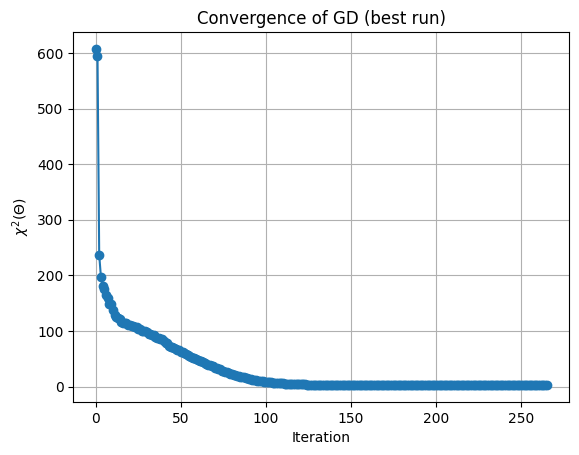

In [5]:
plt.figure()
plt.plot(info_best["path"][:,0], info_best["path"][:,1], marker='o')
plt.xlabel("Iteration"); plt.ylabel(r"$\chi^2(\Theta)$")
plt.title(r"Convergence of GD (best run)")
plt.grid(True)
plt.show()